## Graphs for the 48 min recording (ripple range)

In [1]:
import Ipynb_importer

In [4]:
import TrodesReader
# import from https://bitbucket.org/mkarlsso/trodes/src/master/ or pip install trodesnetwork
from collections import deque
import numpy as np
import math
from scipy import signal
import matplotlib.pyplot as plt
from pprint import pprint

In [5]:
def bandpass_filter(filter_name, flattened_array, sampling_freq, order, lowcut, highcut):
    if filter_name == 'elliptical':
        sos = signal.ellip(order, 0.01, 120, [lowcut, highcut], btype='bp', output='sos', fs=sampling_freq)
    if filter_name == 'butterworth':
        sos = signal.butter(order, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby1':
        sos = signal.cheby1(order, 1, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')
    if filter_name == 'cheby2':
        sos = signal.cheby2(order, 15, [lowcut, highcut], 'bp', fs=sampling_freq, output='sos')

    y = signal.sosfiltfilt(sos, flattened_array)

    return y


def calculate_rms(buffer):
    square_summed = 0
    for k in buffer:
        square_summed += (k ** 2)

    return math.sqrt(square_summed / len(buffer))


def filter_then_rms(buffer, low_cut, high_cut, threshold):
    filtered_buffer = bandpass_filter('butterworth', buffer, lfp_sampling_rate, 1, low_cut, high_cut)
    current_rms = calculate_rms(filtered_buffer)
    return current_rms >= threshold

In [6]:
# this is the 40 min data : 20211207_E1_124311 
# nTrode used: 28
data_path = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.LFP_nt28ch1.dat'
time_path = 'D:\\Recordings\\20211207_E1_124311.LFP\\20211207_E1_124311.timestamps.dat'

In [7]:
data = TrodesReader.readTrodesExtractedDataFile(data_path)
#pprint(data)

<string>:69: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.


In [8]:
time = TrodesReader.readTrodesExtractedDataFile(time_path)
#pprint(time)

In [9]:
start_time = int(time['first_timestamp'])
time_data = []
for i in time['data']:
    time_data.append((i[0]-start_time)/30000)

In [10]:
# check the total recording length
print(time_data[len(time_data)-1]/60)

39.58271277777778


In [11]:
lfp_sampling_rate = 1500
lfp_sampling_period = (1/lfp_sampling_rate)*(10**9)

sw_lower = 5
sw_upper = 15
ripple_lower = 150
ripple_upper = 250
num_std = 4

In [12]:
all_data = data['data']
lfp_data = []
for i in all_data:
    lfp_data.append(i[0])

ripple_lfp_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
sw_lfp_data = bandpass_filter('butterworth', lfp_data, lfp_sampling_rate, 1, sw_lower, sw_upper)

In [13]:
# %matplotlib notebook
# fig1 = plt.figure()
# plt.plot(time_data,sw_lfp_data)
# plt.plot(time_data,ripple_lfp_data)
# plt.xlabel('Time(s)')
# plt.ylabel('Power(µV)')
# plt.show()

In [14]:
# print(len(time_data))
# print(len(lfp_data))
# print(time_data[-1])

# Detection
### Sample testing range used: 2360000, 2782000

In [15]:
offline_rms = []
offline_time = []
offlineripple250 = []
rawlfp = []
for i in range(2360000, 2782000):
    raw_buffer = lfp_data[i-150:i]
    current_buffer = ripple_lfp_data[i-150:i]
    current_rms = calculate_rms(current_buffer)
    if(current_rms<=250):
        offline_rms.append(current_rms)
        offline_time.append(time_data[i])
        offlineripple250.append(current_buffer)
        rawlfp.append(raw_buffer)

In [16]:
print(len(rawlfp),len(offlineripple250),len(offline_time),len(offline_rms))

421915 421915 421915 421915


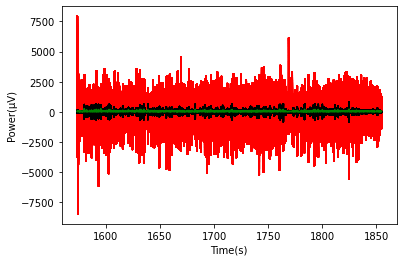

In [17]:
plt.figure()
plt.plot(offline_time, rawlfp, color='r')
plt.plot(offline_time, offlineripple250, color='k', alpha=0.1)
plt.plot(offline_time, offline_rms, color='green')
plt.xlabel('Time(s)')
plt.ylabel('Power(µV)')
plt.show()

In [18]:
online_rms = []
online_time_250 = []
online_time = []
onlineripple250 = []
online_raw250 = []
for i in range(2360000, 2782000):
    online_raw = lfp_data[i-150:i]
    current_buffer = lfp_data[i-150:i]
    current_filtered = bandpass_filter('butterworth', current_buffer, lfp_sampling_rate, 1, ripple_lower, ripple_upper)
    current_rms = calculate_rms(current_filtered)
    online_time.append(time_data)
    if(current_rms<=250):
        online_rms.append(current_rms)
        online_time_250.append(time_data[i])
        onlineripple250.append(current_filtered)
        online_raw250.append(online_raw)

In [19]:
print(len(online_rms),len(online_time_250),len(onlineripple250),len(online_raw250))

421925 421925 421925 421925


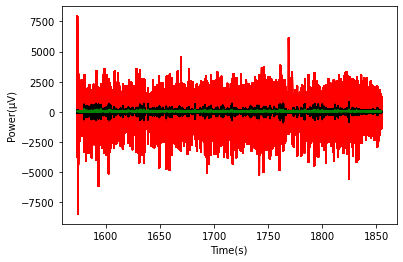

In [20]:
plt.figure()
plt.plot(online_time_250, online_raw250,color='r')
plt.plot(online_time_250,onlineripple250,color='k',alpha=0.1)
plt.plot(online_time_250,online_rms,color='green')
plt.xlabel('Time(s)')
plt.ylabel('Power(µV)')
plt.show()

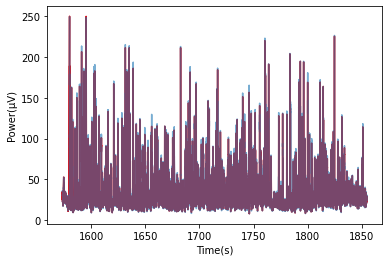

In [21]:
plt.figure()
plt.plot(offline_time, offline_rms,color='r')
plt.plot(online_time_250,online_rms,alpha=0.6)
plt.xlabel('Time(s)')
plt.ylabel('Power(µV)')
plt.show()

# Threshold Calculation

In [22]:
avg_online = np.mean(online_rms)
std_online = np.std(online_rms)
threshold_online = avg_online + num_std*std_online
print(avg_online)
print(std_online)
print(threshold_online)

35.2164999622842
25.247032759674582
136.20463100098254


In [23]:
avg_offline = np.mean(offline_rms)
std_offline = np.std(offline_rms)
threshold_offline = avg_offline + num_std*std_offline
print(avg_offline)
print(std_offline)
print(threshold_offline)

35.55870075639008
25.40956600699733
137.19696478437942


# Z scores

In [24]:
zscore_online = []

for i in range(0,len(online_rms)):
    zscore_online.append((online_rms[i]-avg_online)/std_online)
    
zscore_offline = []

for i in range(0,len(offline_rms)):
    zscore_offline.append((offline_rms[i]-avg_offline)/std_offline)

In [25]:
print(len(zscore_online),len(zscore_offline),len(online_time_250),len(offline_time))

421925 421915 421925 421915


# Decision and stimulation

In [26]:
online_decision = [False, False]
online_stimulation = []

for i in range(0,len(online_rms)):
    online_decision.append(online_rms[i]>threshold_online)
    current_stimulation = True
    for m in range(len(online_decision)-3,len(online_decision)):
        if not online_decision[m]:
            current_stimulation = False
    online_stimulation.append(current_stimulation)  

In [27]:
online_decision.pop(0)
online_decision.pop(0)

False

In [35]:
offline_decision = [False, False]
offline_stimulation = []

for i in range(0,len(offline_rms)):
    offline_decision.append(offline_rms[i]>threshold_offline)
    current_stimulation = True
    for m in range(len(offline_decision)-3,len(offline_decision)):
        if not offline_decision[m]:
            current_stimulation = False
    offline_stimulation.append(current_stimulation) 

In [36]:
offline_decision.pop(0)
offline_decision.pop(0)

False

In [28]:
print(len(online_time_250),len(online_time),len(online_decision),len(online_stimulation))

421925 422000 421925 421925


In [29]:
print(type(online_time_250))

<class 'list'>


In [30]:
# plt.figure()
# plt.plot(online_time_250, online_decision,color='r')
# plt.plot(online_time_250, online_stimulation,color='k',alpha=0.3)
# plt.show()

In [31]:
# plt.figure()
# plt.plot(online_time_250,online_rms)
# plt.plot(online_time_250,onlineripple250, color='r',alpha=0.1)
# plt.axhline(y=threshold_online, color='green',linewidth = '1',label='Threshold')
# plt.xlabel('Time')
# plt.ylabel('Power')
# plt.show()

In [32]:
# plt.figure()
# plt.plot(online_time,online_rms,color='k',alpha=0.5)
# plt.plot(online_time250,onlineripple250, color='r',alpha=0.1)
# plt.axhline(y=threshold_offline, color='green',linewidth = '1',label='Threshold')
# plt.xlabel('Time')
# plt.ylabel('Power')
# plt.show()

In [33]:
onlineStimArr = np.array(online_stimulation)
print(len(onlineStimArr))

421925


# Figure

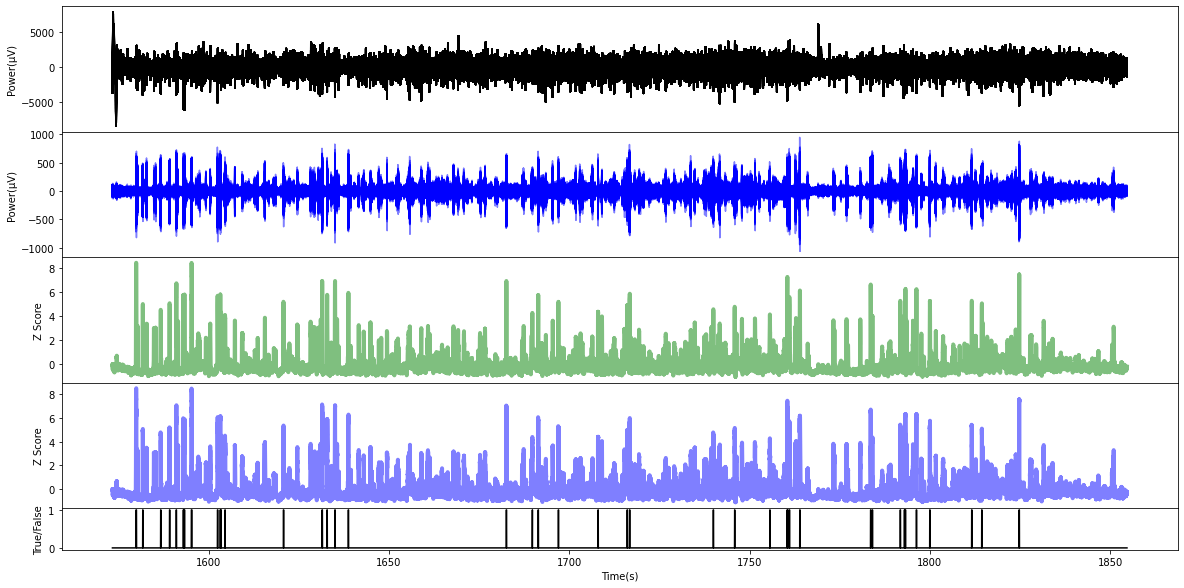

In [34]:
fig4 = plt.figure(figsize=(20,10))
# plt.style.use("seaborn-white")
grid1 = plt.GridSpec(13, 1, wspace=0, hspace=0)
ax1 = plt.subplot(grid1[0:3, 0:1])
ax2 = plt.subplot(grid1[3:6, 0:1])
ax3 = plt.subplot(grid1[6:9, 0:1])
ax4 = plt.subplot(grid1[9:12, 0:1])
ax5 = plt.subplot(grid1[12, 0:1])

ax1.plot(online_time_250,online_raw250, color='k', alpha=0.5, label='Raw LFP')
ax1.set_ylabel("Power(µV)", fontsize=10)
# ax1.legend(fontsize=6)

ax2.plot(online_time_250,onlineripple250, color='b', alpha=0.5, label='Ripple Filtered Band')
ax2.set_ylabel("Power(µV)", fontsize=10)
# ax2.legend(fontsize=6)

ax3.plot(offline_time, zscore_offline, color='g', linewidth='4', alpha=0.5, label='Offline Z-scored RMS')
ax3.set_ylabel("Z Score", fontsize=10)
# ax3.legend(fontsize=6)

ax4.plot(online_time_250, zscore_online, color='b', linewidth='4', alpha=0.5, label='Online Z-scored RMS')
ax4.set_ylabel("Z Score", fontsize=10)
# ax4.legend(fontsize=6)

ax5.plot(online_time_250,onlineStimArr,color='k')
ax5.set_ylabel("True/False", fontsize=10)
#ax5.legend(['Stimulation Status'], fontsize=30)
ax5.set_xlabel('Time(s)', fontsize=10)

plt.show()